Current system is Ubuntu
[-0.24       -0.33333333 -0.25925926 -0.25        0.58823529  0.5
  0.13333333  0.38095238 -0.13636364 -0.19047619 -0.28571429 -0.23809524
  0.52631579 -0.06666667 -0.56521739 -0.38095238  0.         -0.44444444
 -0.4         0.26315789 -0.66666667 -0.36       -0.86363636 -0.33333333
 -0.43333333 -0.76       -0.5        -0.16666667 -0.42307692 -0.25
 -0.04347826  0.125      -0.25       -0.25       -0.08333333 -0.08
 -0.36363636 -0.04761905 -0.6875     -0.5483871  -0.03846154 -0.56521739
  0.          0.16666667 -0.13043478 -0.61904762  0.06666667 -0.71428571
 -0.56521739 -0.34615385  0.33333333  0.63157895 -0.375       0.6
 -0.125      -0.5        -0.53846154 -0.17647059  0.14285714  0.5
 -1.          0.         -0.25       -0.31578947]
SVR - MSE: 0.1379295565572517
RandomForest - MSE: 0.15430900040491535


No handles with labels found to put in legend.


GradientBoosting - MSE: 0.15635916345939765
XGB - MSE: 0.17711124127176528
Lasso - MSE: 0.1381289995196207
Ridge - MSE: 0.1387272230185426
ElasticNet - MSE: 0.1381289995196207
KNeighbors - MSE: 0.1514819399489181


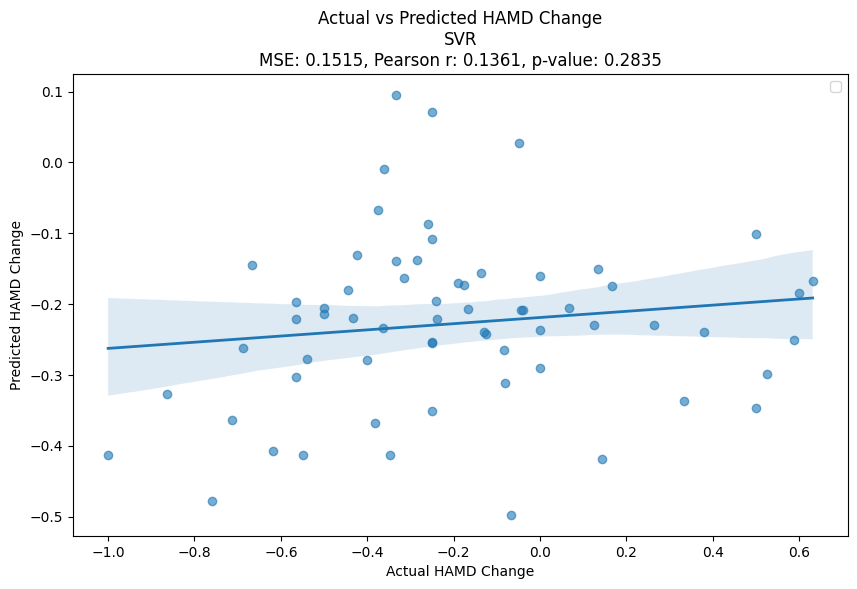

No handles with labels found to put in legend.


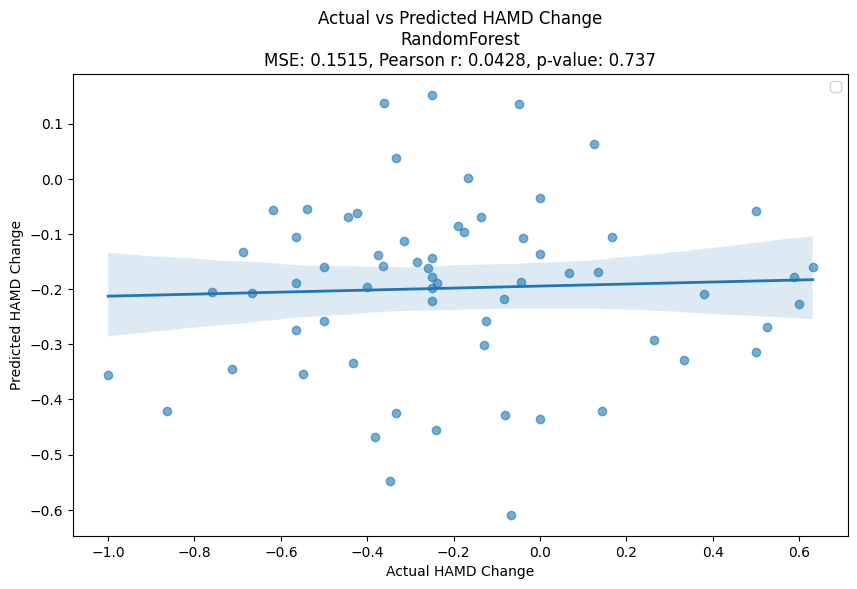

No handles with labels found to put in legend.


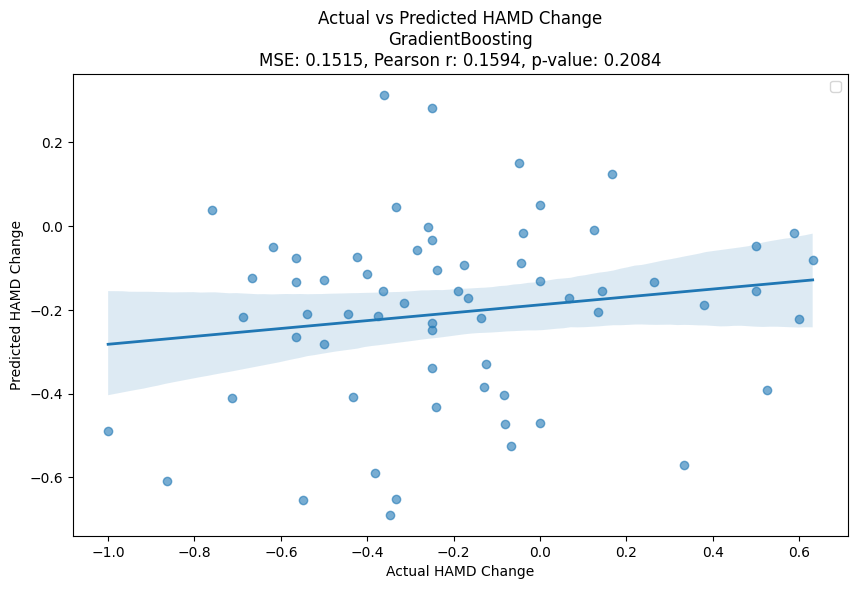

No handles with labels found to put in legend.


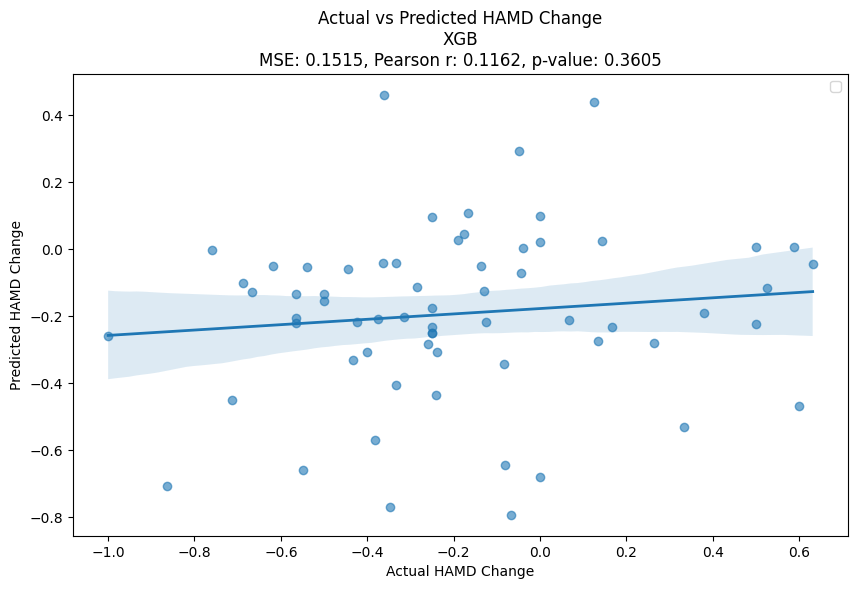

No handles with labels found to put in legend.


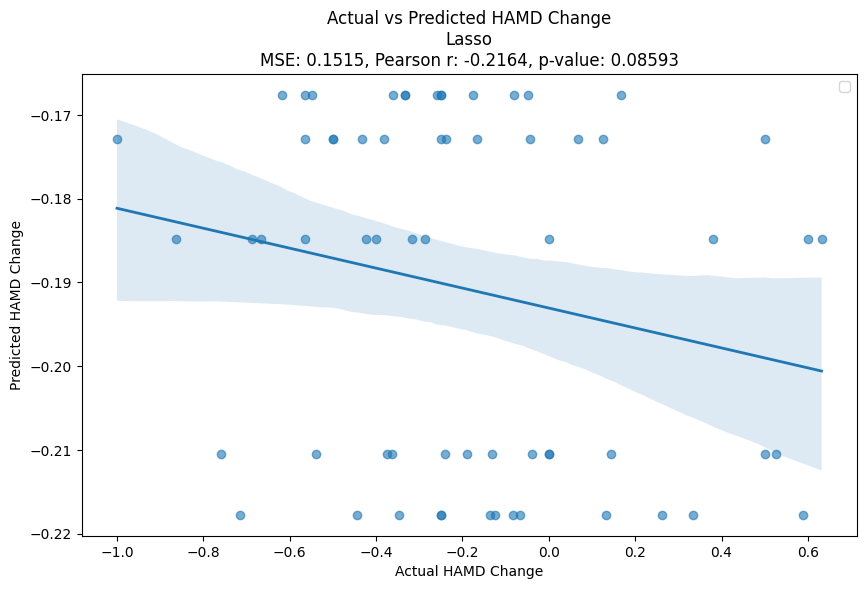

No handles with labels found to put in legend.


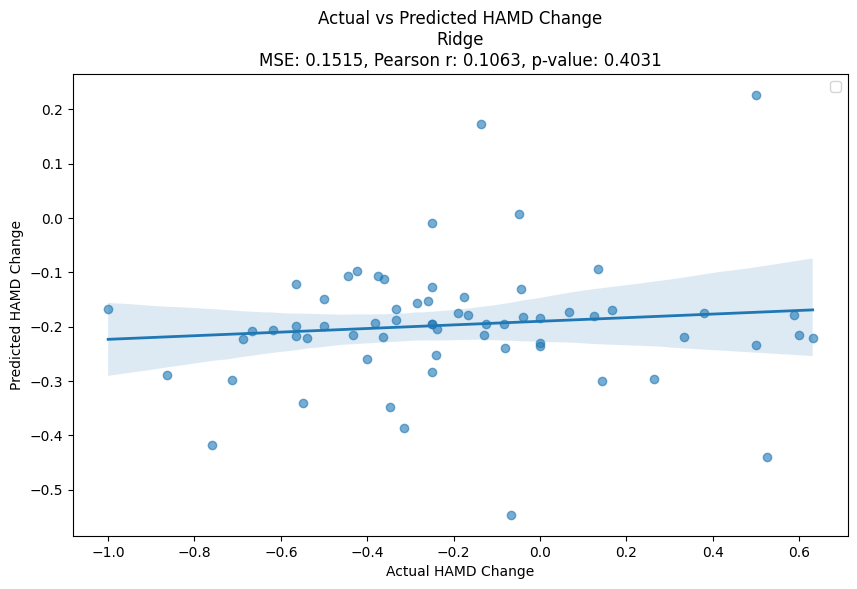

No handles with labels found to put in legend.


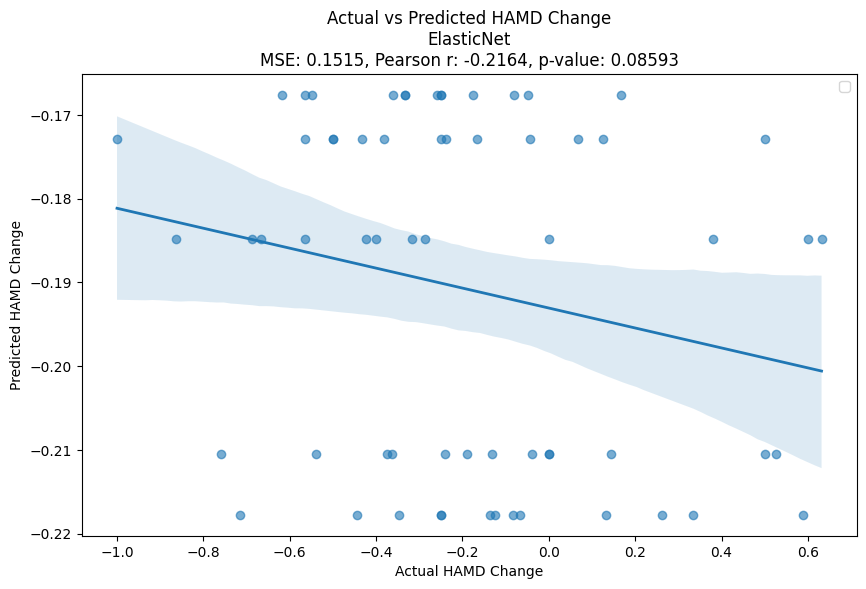

No handles with labels found to put in legend.


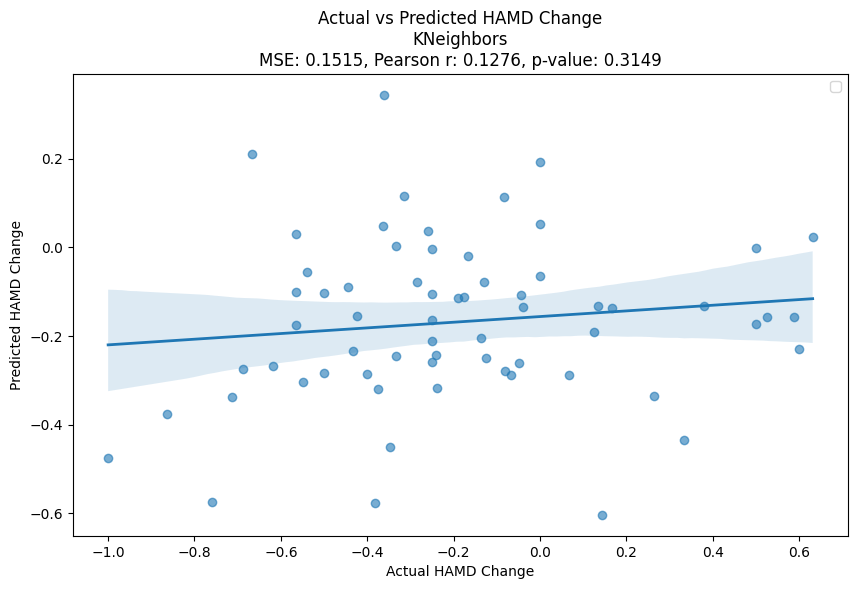

In [9]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.linear_model import Lasso, Ridge, ElasticNet


def set_path():
    if sys.platform == 'darwin':
        print("Current system is macOS")
        main_fold_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction'
    elif sys.platform == 'linux':
        print("Current system is Ubuntu")
        main_fold_path = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning'
    else:
        print("Current system is neither macOS nor Ubuntu")
    os.chdir(main_fold_path)

def change_hamd_to_percent(labels):
    res = labels[:, 1] - labels[:, 0]
    res = res / labels[:, 0]
    return res 

def load_data():
    data_pth = 'allData/prognosis_mix_hb/pretreatment_response/nor_demo_cli_merge_data.npy'
    label_pth = 'allData/prognosis_mix_hb/pretreatment_response/label_hamd.npy'
    data = np.load(data_pth)
    labels = np.load(label_pth)
    labels = change_hamd_to_percent(labels)
    return data, labels

def add_cgi(data):
    cgi_path = 'allData/prognosis_mix_hb/pretreatment_response/nor_T2_SDS_CGI.npy'
    cgi = np.load(cgi_path)
    data = np.concatenate((data, cgi[:, -2:]), axis=1)
    return data

def add_mddr(data):
    mddr_path = 'allData/prognosis_mix_hb/pretreatment_response/MDDR/MDDR_derived_from_load_evaluate.npy'
    mddr = np.load(mddr_path)
    mddr = mddr[..., -1]
    mddr = np.transpose(mddr, (1, 0))
    data = np.concatenate((data, mddr), axis=1)
    return data
    
    
def regression(data, labels):
    # Define the regressors
    regressors = {
        "SVR": SVR(),
        "RandomForest": RandomForestRegressor(),
        "GradientBoosting": GradientBoostingRegressor(),
        "XGB": XGBRegressor(),
        "Lasso": Lasso(),
        "Ridge": Ridge(),
        "ElasticNet": ElasticNet(),        
        "KNeighbors": KNeighborsRegressor()
    }

    # Define the cross-validation strategy
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform regression using each regressor with cross_val_predict
    predictions = {}
    for name, reg in regressors.items():
        preds = cross_val_predict(reg, data, labels, cv=cv)
        predictions[name] = preds
        mse = mean_squared_error(labels, preds)
        print(f"{name} - MSE: {mse}")

    # Plot the actual vs predicted values
    for name, preds in predictions.items():
        r, p_value = pearsonr(labels, preds)
        plt.figure(figsize=(10, 6))
        sns.regplot(x=labels, y=preds, scatter_kws={'alpha':0.6}, line_kws={"linewidth":2})

        # Calculate Pearson correlation
        
        plt.title(f'Actual vs Predicted HAMD Change\n{name}\nMSE: {mse:.4f}, Pearson r: {r:.4f}, p-value: {p_value:.4g}')
        plt.xlabel('Actual HAMD Change')
        plt.ylabel('Predicted HAMD Change')
        plt.legend()
        plt.show()
    

if __name__ == "__main__":
    # Change the working directory to the main folder
    set_path()
    from utils_simple_prediction import add_task_change_data
    
    # Load the data
    data, labels = load_data()
    # data = add_cgi(data)
    data = data[:, :]
    data = add_mddr(data)
    data = add_task_change_data(data)
    data = data[:, -9:]
    print(labels)
    
    # Perform regression and plot results
    regression(data, labels)
